# Fast ICA & the independent components of image patches

## Paola Suaréz, Elisabeth Kress, Esra Zihni, Jiameng Wu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.decomposition import FastICA
from time import time
from sklearn.feature_extraction.image import extract_patches_2d

%matplotlib inline

## 7.1 Negentropy is scale-invariant

In [2]:
a = plt.imread("analytical.jpg")

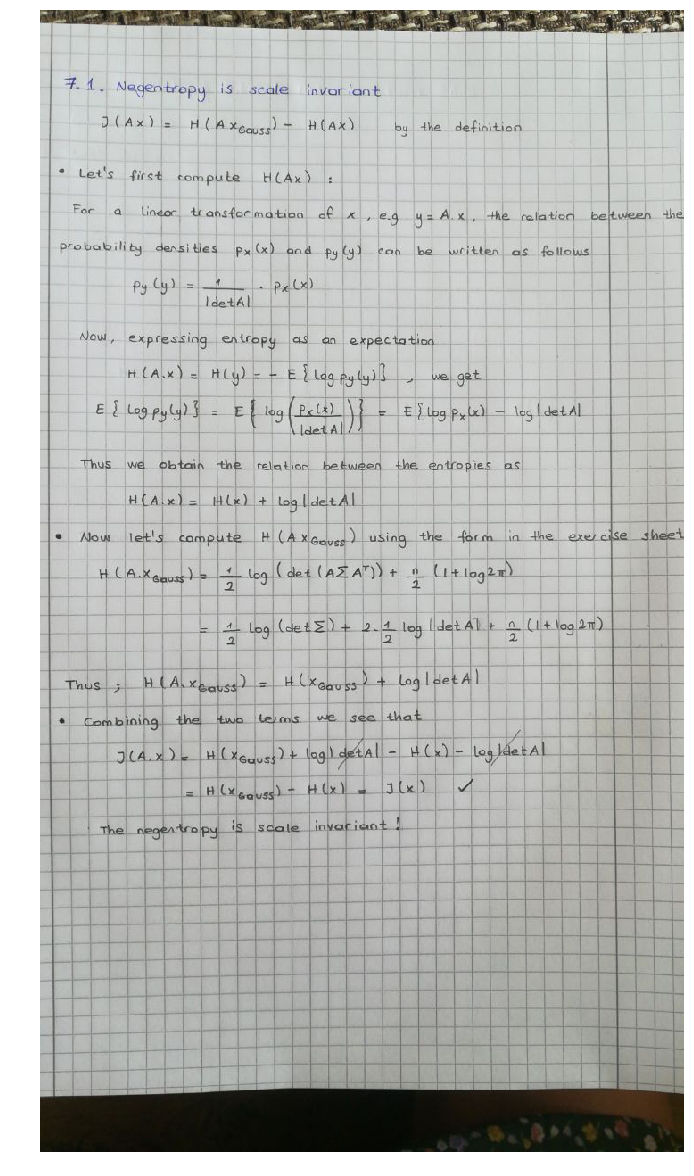

In [23]:
plt.figure(figsize=(18,21))
plt.imshow(a)
plt.axis("off")
plt.show()

## 7.2 fastICA vs. Infomax

In [4]:
# Helper function for the transformed data
def logistic(y):
    return 1/(1+np.exp(-y))

# Helper fucntion for invertible matrix
def invert(N=3):
    #matrix = np.random.normal(loc=mu, scale=sigma, size=(N, N)) #scipy.stats.ortho_group.rvs
    matrix = np.random.uniform(0, 1, (N, N))
    exception = True
    while exception:
        try:
            np.linalg.inv(matrix)
        except:
            matrix = np.random.uniform(0, 1, (N, N))
        else:
            exception = False
    return matrix

# natural gradient ascent
def nat_meng(data, w0, eps=0.01, lamb=0.9999):
    """
    Computes natural gradient ascent on an array of mixed sounds in order to obtain the best weight matrix.
    data: an array containing mixed sources.
    w0: initial weight matrix, randomly generated.
    returns
    ws: an array of all the evolution of weights.
    """
#    ws = np.zeros((data.shape[1]+1, data.shape[0], data.shape[0]))
#     ws[0] = w0
    dim = data.shape[0]
    length = data.shape[1]
    W = w0
    for t in np.arange(length):
        x = data[:, t]
#        W = ws[t].copy()
        eps = eps * lamb
        #eps = eps0/(t+1)
        delta = np.identity(dim)
        u = np.dot(W, x)
        update = np.dot(delta, W) + np.dot((1- 2*logistic(u)).reshape(dim,1), np.dot(u.reshape(1,dim), W))
        delta_W = eps * update
        W += delta_W
#        ws[t+1] = W
    return W

In [5]:
# Load sounds
source1 = np.loadtxt('sound1.dat')
source2 = np.loadtxt('sound2.dat')
original = np.array([source1, source2])

In [6]:
# Create an invertible mixing matrix
A = invert(2)

# Mix the sources
mixed = np.dot(A, original)

# Center the data
mixed_c = np.subtract(mixed.T, mixed.mean(axis=1)).T

# Initialize weights
W0 = invert(2)

In [7]:
start1 = time()

# Run natural gradient
W = nat_meng(mixed_c, W0)

# Unmixed
# W = Ws[-1]
unmixed = np.dot(W, mixed_c)

end1 = time()

In [8]:
start2 = time()

# Run FastICA
ica = FastICA(2)
S_ = ica.fit_transform(mixed.T).T
A_ = ica.mixing_

end2 = time()

In [9]:
# Compare computational cost
nat_time = end1-start1
fast_time = end2-start2
print("Computational time")
print("Natural gradient: %.4f" %nat_time)
print("Fast ICA: %.4f" %fast_time)

Computational time
Natural gradient: 0.4923
Fast ICA: 0.0236


#### Try audios

In [10]:
Audio(unmixed[1], rate=8192)

In [11]:
Audio(S_[0], rate=8192)

Fast ICA algorithm is always better in speed and source identification.

## 7.3 ICA on Image Patches

In [12]:
# Read images
nature = []   # 13 nature images
for i in range(13):
    nature.append(plt.imread("imgpca/n"+str(i+1)+".jpg", format='jpg'))

buildings = []   # 10 building images, without considering the zooms of the 9th img.
for i in range(10):
    buildings.append(plt.imread("imgpca/b"+str(i+1)+".jpg", format='jpg'))
    
text = []   # 14 text images
for i in range(14):
    text.append(plt.imread("imgpca/t"+str(i+1)+".jpg", format='jpg'))

### a) Sample P patches of $\sqrt{N}$ x $\sqrt{N}$

In [13]:
# Patches
P = 5000
pix = 16
N = pix*pix

n_patches = np.zeros((len(nature), P, N))
b_patches = np.zeros((len(buildings), P, N))
t_patches = np.zeros((len(text), P, N))

images_ = [nature, buildings, text]
patches_ = [n_patches, b_patches, t_patches]

for i in range(3):
    images = images_[i]
    patches = patches_[i]
    for j in range(len(images)):
        patches[j,:,:] = extract_patches_2d(images[j], (pix, pix), max_patches=P).reshape(P,N)

### b) Independent features of the patches

In [14]:
# Calculating independent features of the images using FastICA
# Standard setting of the FastICA function is whitening and contrast function logcosh a=1
rs = []
As = []
for i in range(3):
    patches = patches_[i].reshape(-1, N)
    patches = np.subtract(patches, np.mean(patches, axis=0))
    
    ica = FastICA(n_components=N, tol=0.01, max_iter=1000)
    #r_ = ica.fit_transform(patches.T)
    A_ = ica.fit(patches).components_
    #rs.append(r_)
    As.append(A_)

### c) First 20 independent features

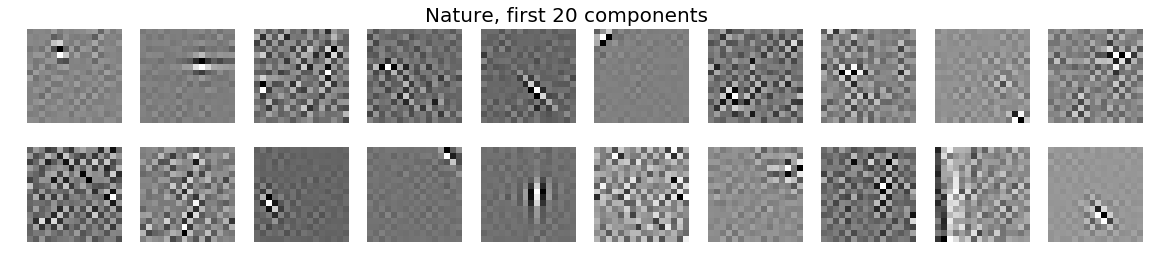

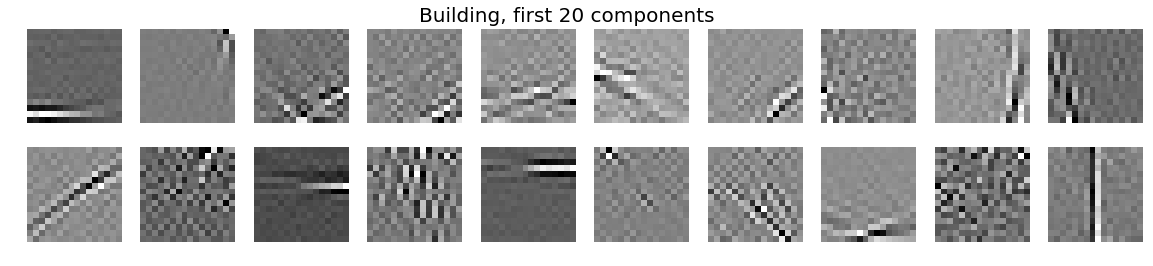

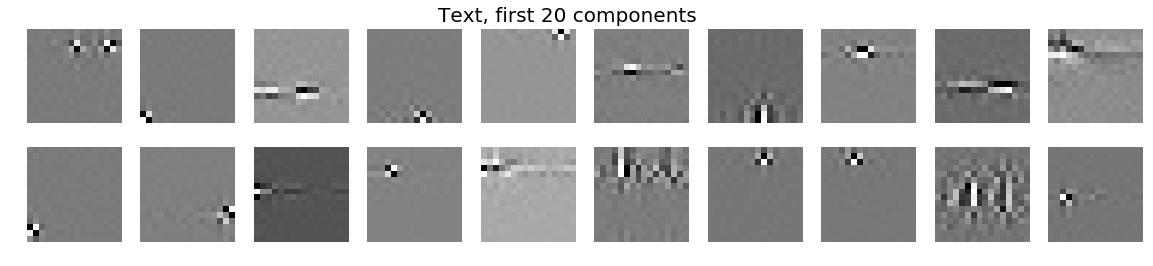

In [15]:
titles = ('Nature', 'Building', 'Text')
for i in range(3):
    f, axes = plt.subplots(2, 10, figsize=(20,4))
    axes = axes.ravel()
    for j in range(20):
        axes[j].imshow(As[i][j,:].reshape((pix,pix)),'gray')#, vmin=np.min(As[i]), vmax=np.max(As[i]))
        axes[j].axis("off")
    plt.suptitle(titles[i]+", first 20 components", fontsize=20, y=.95)
    plt.show()

### d) PCA on the same set of patches

In [16]:
ls = []
ws = []

for i in range(3):
    #image = images_[i][0]
    #size = image.shape[0] * image.shape[1]
    patches = patches_[i].reshape(-1, N)
    patches = np.subtract(patches, np.mean(patches, axis=0))
    
    # PCA
    cov = np.cov(patches.T)
    l, w = np.linalg.eig(cov)
    
    # Sorted eigenvectors
    w = w[:,np.flipud(np.argsort(l))]

    ls.append(l)
    ws.append(w)

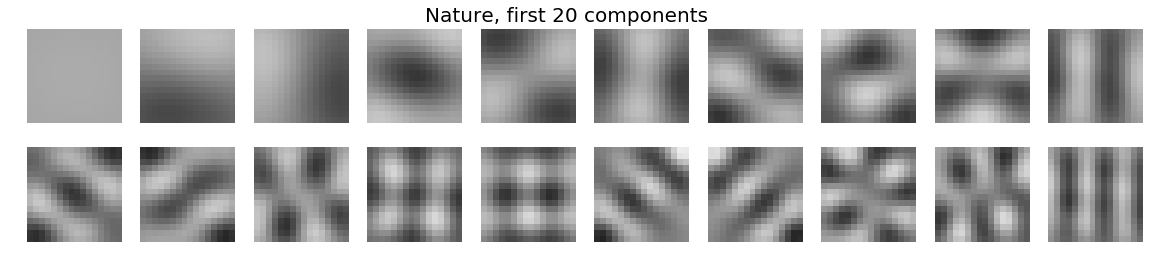

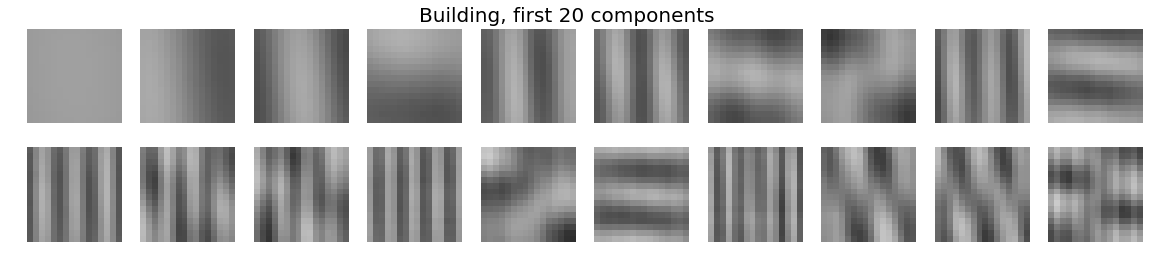

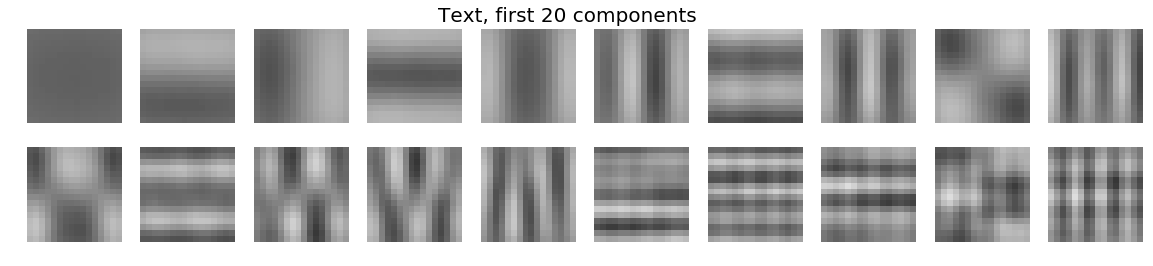

In [17]:
titles = ('Nature', 'Building', 'Text')
for i in range(3):
    f, axes = plt.subplots(2, 10, figsize=(20,4))
    axes = axes.ravel()
    for j in range(20):
        axes[j].imshow(ws[i][:,j].reshape((pix,pix)),'gray', vmin=np.min(ws[i]), vmax=np.max(ws[i]))
        axes[j].axis("off")
    plt.suptitle(titles[i]+", first 20 components", fontsize=20, y=.95)
    plt.show()

### Discussion

The first 20 independent components are different from the corresponding principal components; for fast ICA the resolution is higher and the components appear to concentrate in smaller details. Although the overall structure coincides, i.e. we observe circle for natural images, mainly vertical lines for buildings and mainly horizontal ones for text. The detail can be observe, for example, in the case of buildings lines can be recognise depending on the position and not just on the direction. 

We expected a similar output of fast ICA and PCA, actually we discussed throughly the application of the methods. We have confidence in the results, but fail on explaining why are the components so different.